# import

In [4]:
import sys
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages')
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shutil as sh
import math

Matplotlib is building the font cache; this may take a moment.


# module

In [2]:
class vdw_vol():
    def __init__(self,R1,R2,heri,R3_t,R3_p):
        #毎回使うので変数化
        self.path='C:\\Users\\koyama\\OSC\\interaction\\tetracene\\step3\\vdw\\'
        #step2までの結晶パラメータ
        self.R1=R1;self.R2=R2;self.R3_t=R3_t;self.R3_p=R3_p;self.heri=heri
        #一応rad版も
        self.heri_rad=np.radians(heri)
        #基本並進ベクトル
        self.a_=2*(R1*np.cos(self.heri_rad/2)-R2*np.sin(self.heri_rad/2))
        self.b_=2*(R1*np.sin(self.heri_rad/2)+R2*np.cos(self.heri_rad/2))
        self.a=np.array([self.a_,0.0,2*R3_t-R3_p])
        self.b=np.array([0.0,self.b_,R3_p])
        #精度
        self.interval=0.1
        #層2の最近接分子7つの[A3,[Ra_i,Rb_i,R3_i]]
        self.BTBT_set=[[heri/2,[0,0,0]],[heri/2,[0,self.b_,R3_p]],[heri/2,[0,-self.b_,-R3_p]],
                     [-heri/2,[self.a_/2,self.b_/2,R3_t]],[-heri/2,[-self.a_/2,self.b_/2,-R3_t+R3_p]],
                       [-heri/2,[self.a_/2,-self.b_/2,R3_t-R3_p]],[-heri/2,[-self.a_/2,-self.b_/2,-R3_t]]]
        #分子をz方向から見たときの横幅。プロット用
        self.l1=2.4873612575871507
        self.l2=2.1382975723588693
        
    #ロドリゲスの回転行列
    def Rod(self,n,theta_in):
        nx,ny,nz=n
        theta_t=np.radians(theta_in)
        Rod=np.array([[np.cos(theta_t)+(nx**2)*(1-np.cos(theta_t)),nx*ny*(1-np.cos(theta_t))-nz*np.sin(theta_t),nx*nz*(1-np.cos(theta_t))+ny*np.sin(theta_t)],
                    [nx*ny*(1-np.cos(theta_t))+nz*np.sin(theta_t),np.cos(theta_t)+(ny**2)*(1-np.cos(theta_t)),ny*nz*(1-np.cos(theta_t))-nx*np.sin(theta_t)],
                    [nx*nz*(1-np.cos(theta_t))-ny*np.sin(theta_t),ny*nz*(1-np.cos(theta_t))+nx*np.sin(theta_t),np.cos(theta_t)+(nz**2)*(1-np.cos(theta_t))]])
        return Rod

    #分子1分子2を作成。rot(deg)回転・r(np.array)ベクトルだけ並進
    def convertor(self,atom_list,r,rot):
        atom_list_rt=[]
        for x,y,z,R in atom_list:
            x1,y1,z1=np.matmul(self.Rod(np.array([0,0,1]),rot),np.array([x,y,z]).T)
            atom_list_rt.append([x1+r[0],y1+r[1],z1+r[2],R])
        return np.array(atom_list_rt)


####層1,2のある分子ペアの重心・回転角入れるとぶつかるΔR3返す関数
#G1=(0,0,0),theta_1=self.heri/2,G2=(Ra_i0,Rb_i0,R3_i0),theta_2=self.heri/2とか
    def vdw_R3(self,G1,G2,theta_1,theta_2):#G1[2]はとりま意味ない
        #monomer読み込み:xyzとvdw半径
        df_mono=pd.read_csv(self.path+'monomer.csv')###x,y,z,rad
        mono=df_mono[['X','Y','Z','R']].values
        
        mono_1=self.convertor(mono,[G1[0],G1[1],0.0],theta_1)#G1だけ並進・theta_1だけ回転。R3=0にしてとりまぶつかるときのΔR3もとめる。
        mono_1=[line for line in mono_1 if line[2]>0.0]#ぶつかりえない遠い側の原子は除去                
                    
        mono_2=self.convertor(mono,[G2[0],G2[1],0.0],theta_2)#同様
        mono_2=[line for line in mono_2 if line[2]<0.0]
        
        #初期化
        R3_clps=0 
        
        #層1の分子 a軸=x軸 b軸=y軸
        for x1,y1,z1,rad1 in mono_1:#下の層(層1)
            for x2,y2,z2,rad2 in mono_2:#上の層(層2)
                R_21ab=np.array([x2-x1,y2-y1])#1からみた2のab平面内ベクトル
                R3_sq=(rad1+rad2)**2-np.linalg.norm(R_21ab)**2
                if R3_sq>=0:#分子2をz方向に動かしてぶつかるなら更新
                    R3_clps=max(R3_clps,z1+np.sqrt(R3_sq)+(-z2))#ぶつかるときのΔR3^2=分子1→原子1+原子間距離+原子2→分子2
        return R3_clps

    #t字のやつをcell内へ
    def into_cell(self,Ra,Rb): 
        Ra_rt=Ra-((Ra+self.a_/2)//self.a_)*self.a_
        Rb_rt=Rb-((Rb+self.b_/2)//self.b_)*self.b_
        R3_rt=self.R3_t-((Ra+self.a_/2)//self.a_)*(2*self.R3_t-self.R3_p)-(((Rb+self.b_/2)//self.b_))*self.R3_p
        return Ra_rt,Rb_rt,R3_rt

    def make_csv(self,name_csv):
        df_vdw=pd.DataFrame(columns=['Ra','Rb','R3','V'])
        
        #セルの範囲内で隣接層との位置関係R21_i=(Ra,Rb)を動かす
        Ra_list=[round(Ra,1) for Ra in np.linspace(-np.round(self.a_/2,1),np.round(self.a_/2,1),int(2*np.round(self.a_/2,1)/self.interval)+1)]
        Rb_list=[round(Rb,1) for Rb in np.linspace(-np.round(self.b_/2,1),np.round(self.b_/2,1),int(2*np.round(self.b_/2,1)/self.interval)+1)]

        #各隣接層位置についてvdw体積求める
        for Ra_i0 in Ra_list:
            for Rb_i0 in Rb_list:
                #初期化
                R3_clps=0
                for theta_1,G1 in self.BTBT_set:
                    delR3_i0=self.vdw_R3(G1=G1,G2=[Ra_i0,Rb_i0,0.0],theta_1=theta_1,theta_2=self.heri/2)#ぶつかるi0のΔR3
                    Ra_it,Rb_it,R3_it=self.into_cell(Ra_i0+self.a_/2,Rb_i0+self.b_/2)#i0から見たitの位置
                    delR3_it=self.vdw_R3(G1=G1,G2=[Ra_it,Rb_it,0.0],theta_1=theta_1,theta_2=-self.heri/2)#ぶつかるitのΔR3
                    R3_clps=max([R3_clps,G1[2]+delR3_i0,G1[2]+delR3_it+(-R3_it)])
                    #i0がぶつかるときのR_i0=G1+ぶつかるときの(1→i0)
                    #itがぶつかるときのR_i0=G1+衝突するときの(1→it)+(it→i0)
                c=np.array([Ra_i0,Rb_i0,R3_clps]);V=np.dot(np.cross(self.a,self.b),c)
                data=pd.Series([Ra_i0,Rb_i0,R3_clps,V],index=df_vdw.columns)
                df_vdw=df_vdw.append(data,ignore_index=True)
        self.df_vdw=df_vdw
        df_vdw.to_csv(self.path+name_csv)

##################################
    def BTBT_make(self,theta_,G,color='blue'):  
        BTBT_list=[[self.l1*np.cos(np.radians(theta_))+G[0],self.l2*np.sin(np.radians(theta_))+G[1]],[-self.l2*np.cos(np.radians(theta_))+G[0],-self.l2*np.sin(np.radians(theta_))+G[1]]]
        plt.plot([BTBT_list[0][0],BTBT_list[1][0]],[BTBT_list[0][1],BTBT_list[1][1]],color)

    def cmap(self,name_csv=False):
        df_vdw=pd.read_csv(self.path+name_csv)
        Ra_list=df_vdw['Ra']
        Rb_list=df_vdw['Rb']
        R3_list=df_vdw['R3']
        V_list=df_vdw['V']
        self.BTBT_plot=[[90+self.heri/2,[0,0,0]],[90+self.heri/2,[0,self.b_,self.R3_p]],[90+self.heri/2,[0,-self.b_,-self.R3_p]],
                     [90-self.heri/2,[self.a_/2,self.b_/2,self.R3_t]],[90-self.heri/2,[-self.a_/2,self.b_/2,-self.R3_t+self.R3_p]],[90-self.heri/2,[self.a_/2,-self.b_/2,self.R3_t-self.R3_p]],[90-self.heri/2,[-self.a_/2,-self.b_/2,-self.R3_t]]]
        for theta,G in self.BTBT_plot:
            self.BTBT_make(theta,G)
        plt.rcParams['font.size']=15
        plt.rcParams['figure.figsize']=10,10
        sc=plt.scatter(Ra_list,Rb_list,vmin=min(V_list), vmax=max(V_list), c=V_list, cmap='coolwarm')
        plt.xlabel('a lattice Å')
        plt.ylabel('b lattice Å')
        plt.title('lattice Volume')
        plt.colorbar(sc)
        print('min:V={} Ra={} Rb={} R3={}'.format(min(V_list),Ra_list[np.argmin(V_list)],Rb_list[np.argmin(V_list)],np.round(R3_list[np.argmin(V_list)],2)))
    
    def make_QE(self,Rai0,Rbi0,R3i0):
        path_QE='C:\\Users\\koyama\\OSC\\interaction\\tetracene\\QE\\'
        
        theta_rt=np.radians(self.heri)
        b_=2*(self.R1*np.sin(theta_rt/2)+self.R2*np.cos(theta_rt/2))
        a_=2*(self.R1*np.cos(theta_rt/2)-self.R2*np.sin(theta_rt/2))
        
        a=[a_,0.0,2*self.R3_t-self.R3_p]
        b=[0.0,b_,self.R3_p]
        c=[Rai0,Rbi0,R3i0]
        
        df_mono=pd.read_csv('C:\\Users\\koyama\\OSC\\interaction\\tetracene\\vdw\\monomer.csv')###x,y,z,rad
        mono=df_mono[['X','Y','Z','R','atom']].values
        atoms=mono[:,-1]
        mono=mono[:,:4]
        mono_i=self.convertor(mono,[0.0,0.0,0.0],self.heri/2)
        mono_t=self.convertor(mono,[a_/2,b_/2,self.R3_t],-self.heri/2)
        mono_i=mono_i[:,:3]
        mono_t=mono_t[:,:3]
        
        xyz_i=[];xyz_t=[]
        for ind,atom in enumerate(atoms):
            x,y,z=mono_i[ind]
            xyz_i.append(atom+' '+str(x)+' '+str(y)+' '+str(z)+'\n')
        for ind,atom in enumerate(atoms):
            x,y,z=mono_t[ind]
            xyz_t.append(atom+' '+str(x)+' '+str(y)+' '+str(z)+'\n')
        
        ####formatのxyz座標いれるべき部分をみつけてくる
        with open(path_QE+'anthracene_format_opt.txt') as f:
            format_=f.readlines()
        for i in range(len(format_)):
            if format_[i].find('ATOMIC_POSITIONS angstrom\n') >= 0:
                ind_xyz=i+1
                break
        
        lattice=[' '+str(a[0])+' '+str(a[1])+' '+str(a[2])+'\n'
         ,' '+str(b[0])+' '+str(b[1])+' '+str(b[2])+'\n'
         ,' '+str(c[0])+' '+str(c[1])+' '+str(c[2])+'\n']
        
        QE_inp=format_[:ind_xyz]+xyz_i+xyz_t+format_[ind_xyz:]+lattice
        file_opt='anth_QE_para.inp'
        with open(path_QE+file_opt,'w') as f:
            f.writelines(QE_inp)
            
        cc01=['mpirun -np 36 pw.x < '+file_opt+'.inp > '+file_opt+'.out \n']
        with open(path_QE+'cc01.txt','w') as f:
            f.writelines(cc01)

# tetracene

１．長軸ずれなし

In [3]:
vdw=vdw_vol(R1=4.6,R2=1.0,heri=53.0,R3_t=0.0,R3_p=0.0)#-42.89

In [5]:
vdw.make_csv(name_csv='R3t=0_R3p=0.csv')

min:V=569.6617290703205 Ra=-1.9 Rb=-0.1 R3=13.16


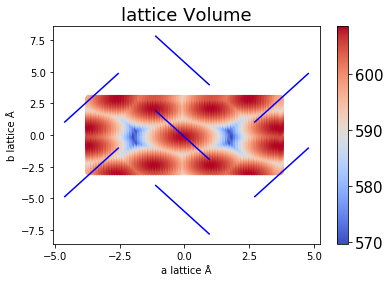

In [6]:
vdw.cmap(name_csv='R3t=0_R3p=0.csv')
# plt.scatter(0.0,-2.6,s=200,marker='D',color='red',label='min')
# plt.scatter(-1.19154,-1.74617,s=200,marker='D',label='C9')

２．環一個分のずれ

In [8]:
vdw=vdw_vol(R1=4.6,R2=1.0,heri=53.0,R3_t=2.1,R3_p=2.0)#-40.430

min:V=568.7375581214899 Ra=0.0 Rb=1.4 R3=13.62


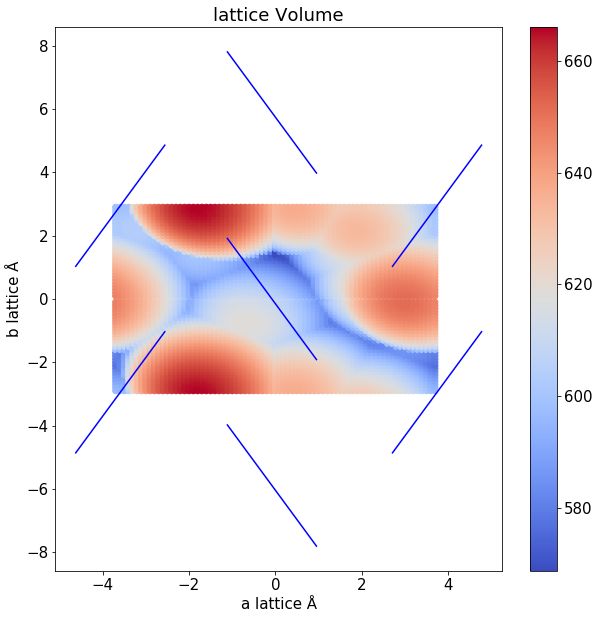

In [10]:
#vdw.make_csv(name_csv='R3t=2.1_R3p=2.0.csv')
vdw.cmap(name_csv='R3t=2.1_R3p=2.0.csv')

３．T-shapeのみ一個分のずれ

In [11]:
vdw=vdw_vol(R1=4.6,R2=1.0,heri=53.0,R3_t=2.3,R3_p=0.0)#-39.58

min:V=577.9105541553267 Ra=0.9 Rb=-0.1 R3=13.92


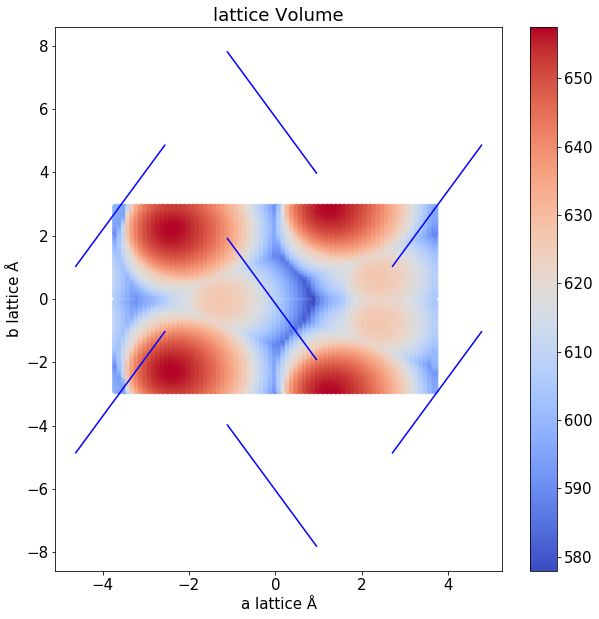

In [12]:
vdw.make_csv(name_csv='R3t=2.3_R3p=0.csv')
vdw.cmap(name_csv='R3t=2.3_R3p=0.csv')

# make QE

In [22]:
vdw=vdw_vol(R1=4.6,R2=1.0,heri=53.0,R3_t=0.0,R3_p=0.0)#-42.89
vdw.make_QE(Rai0=2.0,Rbi0=0.0,R3i0=10.6)